In [1]:
!pip install simpletransformers

     |████████████████████████████████| 204kB 11.9MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 317kB 36.1MB/s 
     |████████████████████████████████| 2.9MB 47.8MB/s 
     |████████████████████████████████| 1.1MB 25.1MB/s 
     |████████████████████████████████| 1.8MB 39.7MB/s 
     |████████████████████████████████| 1.4MB 45.0MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 7.4MB 47.9MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 133kB 53.2MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 163kB 48.5MB/s 
     |████████████████████████████████| 890kB 53.3MB/s 
     |████████████████████████████████| 112kB 53.8MB/s 
     |████████████████████████████████| 4.5MB 45.7MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 122kB 57.0MB

In [2]:
import simpletransformers
from simpletransformers.classification import ClassificationModel
import pandas as pd
import sklearn
import logging
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [3]:
!git clone https://github.com/wangcunxiang/SemEval2020-Task4-Commonsense-Validation-and-Explanation.git

Cloning into 'SemEval2020-Task4-Commonsense-Validation-and-Explanation'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 88 (delta 36), reused 64 (delta 19), pack-reused 0
Unpacking objects: 100% (88/88), done.


## **File Reading**

In [16]:
#Read task A training data
df = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Training  Data/subtaskA_data_all.csv')
df.columns = ['id','text_a','text_b']
taskA_data_train = df.drop('id', inplace=False, axis=1)

print(taskA_data_train.shape)
#Read task A training data answers
taskA_train_ans = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Training  Data/subtaskA_answers_all.csv',header=None)
taskA_train_ans.columns = ['id','labels']
taskA_train_ans.drop('id',inplace=True,axis=1)
print(taskA_train_ans.shape)
answers = taskA_train_ans['labels']
taskA_data_train = taskA_data_train.join(answers)
print(taskA_data_train.head(5))
print(taskA_data_train.shape)

#Read task A testing data
df = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_test_data.csv')
df.columns = ['id','text_a','text_b']
taskA_data_test = df.drop('id', inplace=False, axis=1)
testinggdata = taskA_data_test
#Read task A testing data answers
taskA_test_ans = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_gold_answers.csv',header=None)
taskA_test_ans.columns = ['id','labels']
taskA_test_ans.drop('id',inplace=True,axis=1)
print(taskA_test_ans.shape)
answers = taskA_test_ans['labels']
taskA_data_test = taskA_data_test.join(answers)
print(taskA_data_test)
print(taskA_data_test.shape)
labels = taskA_test_ans.values.reshape(-1).tolist()



#Read task A validation data
df = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Dev Data/subtaskA_dev_data.csv')
df.columns = ['id','text_a','text_b']
taskA_data_dev = df.drop('id', inplace=False, axis=1)
print(taskA_data_dev.shape)
#Read task A validation data answers
taskA_dev_ans = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Dev Data/subtaskA_gold_answers.csv',header=None)
taskA_dev_ans.columns = ['id','labels']
taskA_dev_ans.drop('id',inplace=True,axis=1)
print(taskA_dev_ans.shape)
answers = taskA_dev_ans['labels']
taskA_data_dev = taskA_data_dev.join(answers)
print(taskA_data_dev.head(5))
print(taskA_data_dev.shape)

(10000, 2)
(10000, 1)
                                  text_a                         text_b  labels
0  He poured orange juice on his cereal.  He poured milk on his cereal.       0
1                       He drinks apple.                He drinks milk.       0
2                  Jeff ran a mile today   Jeff ran 100,000 miles today       1
3                   A mosquito stings me             I sting a mosquito       1
4                   A niece is a person.         A giraffe is a person.       1
(10000, 3)
(1000, 1)
                                                text_a  ... labels
0          He loves to stroll at the park with his bed  ...      0
1        The inverter was able to power the continent.  ...      0
2              The chef put extra lemons on the pizza.  ...      0
3                    sugar is used to make coffee sour  ...      0
4    There are beautiful flowers here and there in ...  ...      1
..                                                 ...  ...    ...
995     

## **Model Training**

In [5]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'evaluate_during_training': True,
    'max_seq_length': 50,
    'num_train_epochs': 20,
    'evaluate_during_training_steps': 1000,
    'wandb_project': 'sts-b-medium',
    'train_batch_size': 8,
    'save_model_every_epoch': False,
    'save_steps': False,
    'optimizer':'AdamW',
    'save_checkpoints_steps':False,
    'save_eval_checkpoints': False,
    'use_early_stopping': True,
    'early_stopping_delta': 0.01,
    'early_stopping_metric': "mcc",
    'early_stopping_metric_minimize': False,
    'early_stopping_patience': 5,

}

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [6]:
model = ClassificationModel('roberta', 'roberta-base',  num_labels = 2, use_cuda=True ,args=train_args)
label = 2

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [7]:
from scipy.stats import pearsonr, spearmanr


def pearson_corr(preds, labels):
    return pearsonr(preds, labels)[0]


def spearman_corr(preds, labels):
    return spearmanr(preds, labels)[0]

In [8]:
model.train_model(taskA_data_train, eval_df=taskA_data_dev, pearson_corr=pearson_corr, spearman_corr=spearman_corr)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(21000,
 {'eval_loss': [0.6174458222389221,
   0.56084605884552,
   0.40796913323551415,
   0.44079088070988653,
   0.7235147752882912,
   0.686369983267039,
   0.8566038491143845,
   0.7536356025733985,
   0.7536356025733985,
   0.7598126818640157,
   0.9815322998830815,
   1.0921834714169962,
   0.9135960258638952,
   0.8477061133498791,
   1.2295874231706547,
   1.0547045192389923,
   1.0869529819795862,
   1.0869529819795862,
   0.9314536166094476,
   1.0317543519571772,
   0.9963350337548763,
   0.996467892602901,
   0.8551781271516811,
   1.000954929405707,
   1.0067753925723373,
   1.072896607469942,
   1.072896607469942,
   1.008189221838722,
   1.0374993988930363,
   1.039509587504901,
   1.1337807850346726,
   1.2051155573695724,
   1.1627576631042758,
   1.0787955378568148,
   1.074687465406838,
   1.074687465406838,
   1.0353487507576646],
  'fn': [345,
   160,
   94,
   51,
   86,
   40,
   78,
   79,
   79,
   57,
   52,
   54,
   73,
   74,
   35,
   50,
   86,
   86,
  

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(taskA_data_test, pearson_corr=pearson_corr, spearman_corr=spearman_corr)

_step,2
_runtime,2
_timestamp,1607459841


_step,▁▅█
_runtime,▁▁▁
_timestamp,▁▁▁


## **Predictions on Test Data**

In [13]:
prediction = []
 
for x in model_outputs:
  prediction.append(np.argmax(x))

print("Predictions of the model:")
print(prediction)
print(len(prediction))

Predictions of the model:
[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0

In [14]:
predictions, raw_outputs = model.predict(testinggdata.values.tolist())
print("\t**********Predictons of test set:**********","\n", predictions)
print()
print("\t**********Probabilities of test set classes:**********","\n",raw_outputs)


	**********Predictons of test set:********** 
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

## **Predictions Evaluation**

In [17]:
#*************************ACCURACY********************************
right_pred = 0
for i in range(len(labels)):
  correct = labels[i]
  predicted = predictions[i]
  if(correct == predicted):
    right_pred += 1

accuracy = (right_pred / len(labels)) * 100
print("Accuracy on test data is:",accuracy)

#*************************F1 Score*********************************
f1 = f1_score(labels, predictions)
print("F1 Score on test data is",f1*100)

# calculate average precision score
ap = average_precision_score(labels, predictions)
print("Avergae Precision score of the model is",ap*100)

Accuracy on test data is: 88.1
F1 Score on test data is 87.5912408759124
Avergae Precision score of the model is 83.97442941452968


In [18]:
print(predictions)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 

## **Writing to CSV file**

In [19]:
df = pd.read_csv('SemEval2020-Task4-Commonsense-Validation-and-Explanation/ALL data/Test Data/subtaskA_test_data.csv')
df.columns = ['id','text_a','text_b']

In [20]:
import csv

with open('answers.csv','w', newline = '') as file:
  writer = csv.writer(file)
  for i in range(len(df)):
    writer.writerow([df['id'][i], predictions[i]])

In [21]:
corrected = 0
ans = pd.read_csv('answers.csv', header = None)
ans.columns = ['id','answer']
for index, row in ans.iterrows():
  value = row['answer']
  if(value == predictions[index]):
    corrected += 1
print(corrected)


1000


## **Graphs**

Model predictions [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 

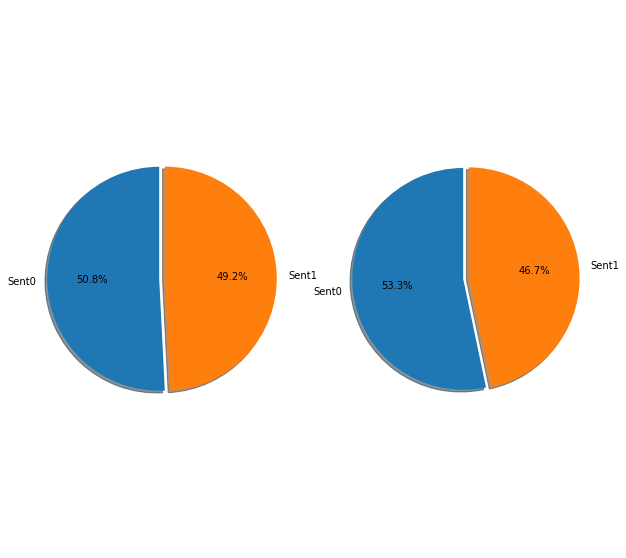

In [22]:
size_l0 = 0
size_l1 = 0
size_p0 = 0
size_p1 = 0
print("Model predictions",predictions)
print("Actual Result",labels)

for i in range(len(labels)):
  if(labels[i] == 0):
    size_l0 += 1
  else: 
    size_l1 += 1
  if(predictions[i] == 0):
    size_p0 += 1
  else:
    size_p1 += 1

# Pie chart for the real test set examples
lab = 'Sent0', 'Sent1',
sizes_l = [size_l0, size_l1]
explode = (0, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.pie(sizes_l, explode=explode, labels=lab, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for the predicted labels on test set examples
sizes_p = [size_p0, size_p1]
explode = (0, 0.05)  
ax2.pie(sizes_p, explode=explode, labels=lab, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



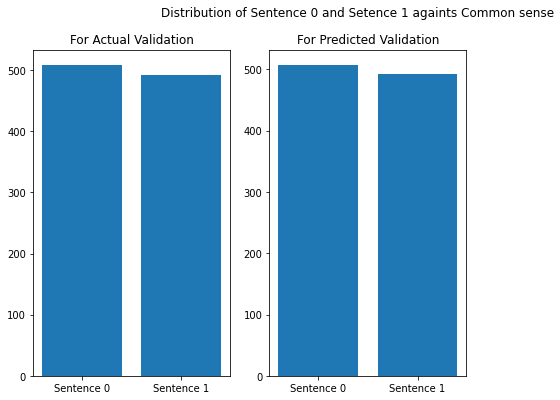

In [ ]:
names = ['Sentence 0', 'Sentence 1']
values = [size_l0,size_l1]

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.bar(names, values)
plt.title("For Actual Validation")
values = [size_p0,size_p1]
plt.subplot(132)
plt.bar(names, values)
plt.title("For Predicted Validation")
plt.suptitle("Distribution of Sentence 0 and Setence 1 againts Common sense")
plt.show()



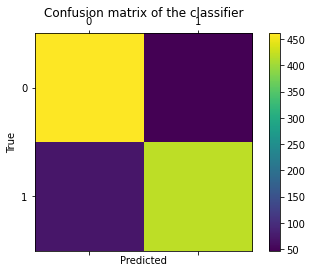

In [24]:
output = ['0','1']
cm = confusion_matrix(labels, predictions, [0,1])
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + output)
ax.set_yticklabels([''] + output)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()